In [675]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import warnings

from src import data, paths, matrix_filtering, communicatin_metrics, plotting
from scipy import signal

from sklearn import metrics as sk_metrics

plt.style.use('ggplot')

!date -I

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-20


# Generalize F-TRACT approach to TMS-EEG

Our goal is to investigate if the TMS evoked response correlates wit structural connectivity and communication metrics similarly as it is shown in [01_f-tract/02_analysis_per_roi.ipynb](../01_f-tract/02_analysis_per_roi.ipynb) for intracranial stimulation.

### Load structural connectivity data

Load structural connectivity data and Euclidean distances and centroids for Schaefer 200 parcellation. `SC_matrices` is a list of tuples `(str, 2D np.array, 2D np.array, 2D np.array)` consisting of: 
- name in a form [dataset]_[group averaging method]
- structural connectivity weights
- structural connectivity lengths
- logarithm of structural connectivity weights

Group averaging method is a string indicating how the group representative connectome was created, options are:
- `simple` simple averaging
- `cons` consensus thresholding
- `dist` distance-dependent consensus thresholding
- `rh` Rosen and Halgren's method

The warnings "divide by zero encountered in log" in the following cell does not bother us because we use the logarithm of weights only for plotting later.

In [676]:
centroids_file = paths.path('interim/schaefer_parcellation_mappings/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")

ED = data.roi_distances_from_centroids(centroids_mne)
SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit(ED=ED)

print("List available structural matrices:\n")
for i, m in enumerate(SC_matrices):
    if m[2] is None:
        sc_l_text = "(lengths NOT available)"
    else:
        sc_l_text = "(lengths available)"
    print(i, m[0], sc_l_text)

List available structural matrices:

0 PyTepFit_simple (lengths available)
1 Enigma_dist (lengths NOT available)
2 Domhof_simple (lengths available)
3 Domhof_cons (lengths available)
4 Domhof_dist (lengths available)
5 Domhof_rh (lengths available)
6 Mica-Mics_simple (lengths available)
7 Mica-Mics_cons (lengths available)
8 Mica-Mics_dist (lengths available)
9 Mica-Mics_rh (lengths available)


#### Settings

- `SELECTED_SC_MATRIX` Selected structural connectivity matrix, default is `Mica-Mics_rh` because there are higest correlations using this matrix in [01_f-tract/01_analysis.ipynb](../01_f-tract/01_analysis.ipynb). See options above. 
- `EMPIRICAL_SIMULATEDN` Select if empirical or simulated TMS-EEG is loaded. 
- `RESPONSE_LENGTH` Miliseconds after stimulations considered as a TMS-evoked response.
- `GRAPH_DENSITY` Desired density of connectome, used for filtering of all the connectivity matrices after they are loaded, set to 0.25 for compatibility with F-Tract results.
- `WHEN_NOT_OVER_THRESHOLD ` When we calculates characteristics of the response, we always set a threshold to filter out baseline activity. If the response in one ROI does not exceed the threshold, it is set to NaN and is not considered in the analysis. Alternatively, we can replace all NaNs in the definitions with zeros and include them in the analysis. The approaches capture different properties of the response.

In [677]:
SELECTED_SC_MATRIX = "PyTepFit_simple"
EMPIRICAL_SIMULATED =   'empirical' # 'simulated' # 
RESPONSE_LENGTH = 200
GRAPH_DENSITY = 0.25

WHEN_NOT_OVER_THRESHOLD = np.nan

In [678]:
fig_dir = f"tmseeg_results/{EMPIRICAL_SIMULATED}/{RESPONSE_LENGTH}/not_over_threshold_{str(WHEN_NOT_OVER_THRESHOLD)}/"
if SELECTED_SC_MATRIX != "Mica-Mics_rh":
    fig_dir+=f"{SELECTED_SC_MATRIX}/"

%mkdir -p  {paths.path_figures(fig_dir)}


results_dir = f'interim/pyTepFit_{EMPIRICAL_SIMULATED}/not_over_threshold_{str(WHEN_NOT_OVER_THRESHOLD)}/'
if SELECTED_SC_MATRIX != "Mica-Mics_rh":
    results_dir+=f"{SELECTED_SC_MATRIX}/"

%mkdir -p {paths.path(results_dir)}

### Select and filter structural connectivity based on settings

Default setting: Select Mica-Mics structural with RH preprocessing, because we already know that it results into correlations for F-Tract. It might be different if the parameter `SELECTED_SC_MATRIX` is changed.

In [679]:
SC_matrices = matrix_filtering.filter_matrices_based_on_density(SC_matrices,GRAPH_DENSITY)

In [680]:
for i, m in enumerate(SC_matrices):
    if SELECTED_SC_MATRIX == m[0]:
        name, SC_W, SC_L, SC_W_log = m
        print(f"{name} selected")

PyTepFit_simple selected


## Load TMS-EEG source reconstructed data

Colser investigation of the data is in [04_exploration.ipynb](./04_exploration.ipynb).

In [681]:
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(paths.path(f'{pytepfit_path}source_estimates/{EMPIRICAL_SIMULATED}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [682]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

Find the stimulated site index based on label (see [02_stimulation-site-extraction.ipynb](./02_stimulation-site-extraction.ipynb) for further information):

In [683]:
stim_locatin = list(data_pytepfit['labels']).index("7Networks_LH_SomMot_9-lh")
stim_time = 100

Create a vector of colors assigned to the responses for individual ROIs based on the ROI name in Schaefer parcellation and Yeo7 network. The parcellation is named using Yeo7 networks, so we can just extract the third part of the name:

In [684]:
color_based_on_yeo7 = []

for x in data_pytepfit['labels']:
    color_based_on_yeo7.append(plotting.COLOR_MAPPING_YEO[x.split("_")[2]])

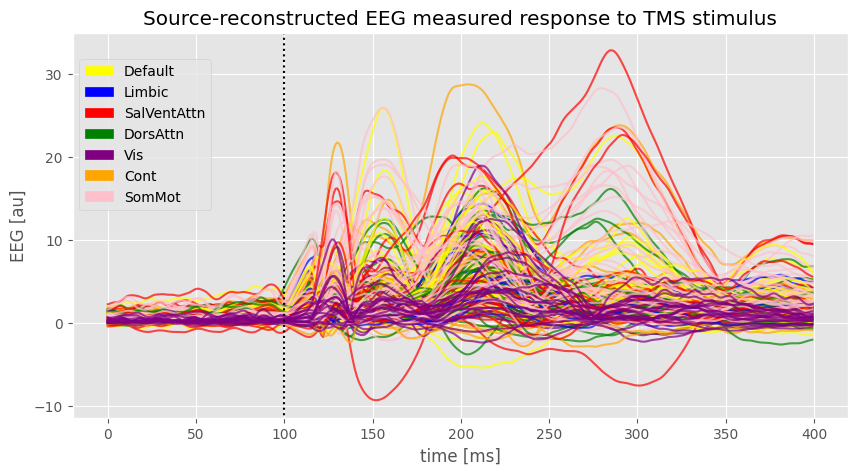

In [685]:
data_ts = data_pytepfit['ts']
plotting.plot_tmseeg_data(data_ts,colors=color_based_on_yeo7,stimulation_time=stim_time,title="Source-reconstructed EEG measured response to TMS stimulus")
plt.savefig(paths.path_figures(fig_dir+"data.pdf"),bbox_inches='tight',pad_inches=0)

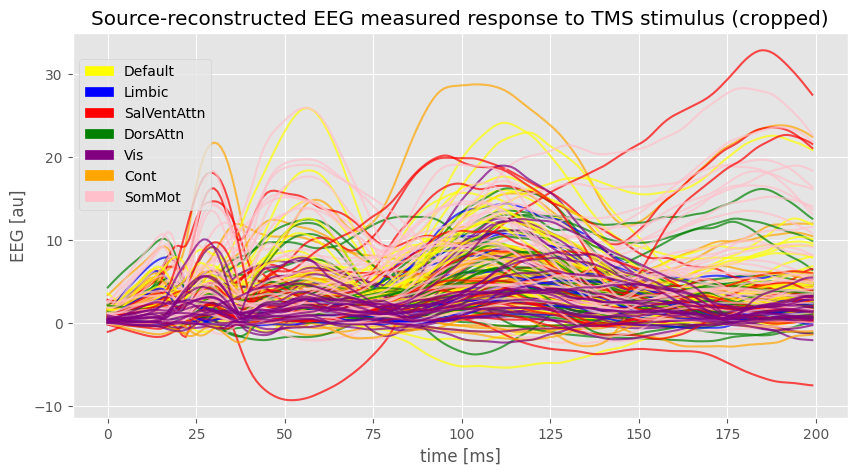

In [686]:
data_ts_croped = data_ts[stim_time:stim_time+RESPONSE_LENGTH,:]
plotting.plot_tmseeg_data(data_ts_croped,colors=color_based_on_yeo7,title="Source-reconstructed EEG measured response to TMS stimulus (cropped)")
plt.savefig(paths.path_figures(fig_dir+"cropped_data.pdf"),bbox_inches='tight',pad_inches=0)
plt.show()

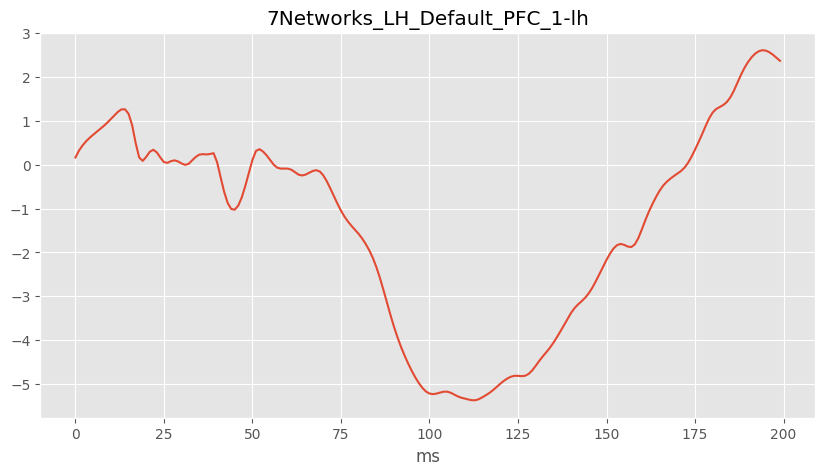

In [687]:
plotting.plot_one_roi_from_tmseeg_data(data_ts_croped,17,data_pytepfit['labels'])

## TMS evoked response characterizations

To follow the methodology used by Seugin et al. for the F-TRACT data, it is necessary to decide how to quantify the time series of each ROI and, followingly, a vector characterizing the response in the whole brain. Our goal is to obtain one number per ROI, similarly to the fact that we have probability for each ROI that it was activated in F-Tract (on row of matrix, unlike TMS data used here, they stimulated more sites). We can not use the probability of the response because the TEPs were measured only in 20 subjects and we have the group-averaged data. Possible response definitions are described in the following cells.

All the response definitions described later work with some threshold. There is always a baseline activity in the brain, as shown in previous plots, see the part before the stimulation. We need to filter out the activity after the stimulation caused by this natural process and keep only responses truly evoked by the TMS stimulation. However, there is nothing like "the right threshold" and it depends on the specific data used in each case. Because of that, we try several thresholds, the lowest corresponding to the highest peak in the activity before the stimulation and the highest selected such that there are at least 30 TEPs over that threshold. 

In [688]:
def peak_analysis(sequence,threshold):
    """
    For sequence and threshold returns first and highest 
    peak (above the threshold) and when they occured.

    If the sequence does not exceedes the threshold, 
    returns NaNs for all the values
    """
    peaks = signal.find_peaks(sequence,height=threshold)
    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_latency = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_latency = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_latency, first_peak_height, max_peak_latency, max_peak_height
    
def get_threshold_range(data,stim_idx):
    """
    
    """
    maxima = np.max(data[stim_idx:,:],axis=0)
    print(maxima.shape)
    maxima.sort()

    upper = int(maxima[-30]) # for higest threshold there should be at least 30 responses above for statistics
    lower = int(np.max(data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    if step <1:
        step = 1

    return range(lower, upper, step)

### List of response characteristics used below

- **(01) response** If the TEP exceeds a predefined threshold, the value is set to 1, otherwise it is set to 0.
- **first/highest peak** The weight of the response is defined as the height of the first/highest peak above a predefined threshold. If the TEP does not exceed the threshold, it is set to nan and is not considered in the analysis.3 The highest peak corresponds to amplitude in F-TRACT
- **first/highest peak latency** The weight of the response is defined as the time when the first/highest peak above a predefined threshold occurs. If the TEP does not exceed the threshold, it is set to nan and is not considered in the analysis. The idea behind this definition is that we assume the response to propagate faster to regions that are „more“ connected (for example, there are edges with higher weights or shorter lengths in structural connectome)
- **AUC** The weight of the response is defined as the area under the curve if the curve exceeds a predefined threshold, nan oth- erwise. The key idea of this definition is that AUC captures the overall „power“ of the response. It is systematically dif- ferent from the other definitions, so it might reveal different relationships.
- others, not used in the end, but kept in the comments: **mean**, **variance**, **difference between highest and lowest value**


Illustration of selected response characteristics:

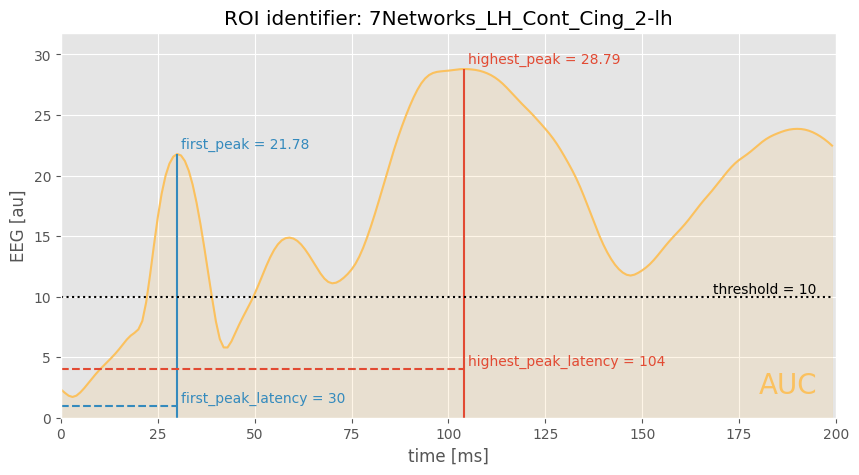

In [689]:
if RESPONSE_LENGTH > 100:

    id_to_plot = 1
    threshold = 10
    selected = data_ts_croped[:,id_to_plot]
    label = data_pytepfit['labels'][id_to_plot]
    peak_analysis_results = peak_analysis(selected,threshold)

    plotting.plot_one_roi_response_definitions(selected_curve=selected,label=label,peak_analysis_result=peak_analysis_results,thr=threshold,resp_length=RESPONSE_LENGTH,fig_dir=fig_dir)

For each threshold from the higest peak in baseline activity to value such that we have enough responses over the threshold to do statistics later, calculate all the response characteristics from the list above 

In [690]:
responses = {} 

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)
list_of_thresholds = []

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.where(np.max(data_ts_croped,axis=0) > threshold,1,0)

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts_croped[:,i],threshold)

    response_df['first_peak_latency'] = peak_analysis_results[:,0]
    response_df['first_peak'] = peak_analysis_results[:,1]
    response_df['highest_peak_latency'] = peak_analysis_results[:,2]
    response_df['highest_peak'] = peak_analysis_results[:,3]

    # response_df['variance'] = np.var(data_ts_croped,axis=0)
    # response_df['diff'] = np.max(data_ts_croped,axis=0)-np.min(data_ts_croped,axis=0)
    # response_df['mean'] = np.array([np.mean(data_ts_croped[:,i]) for i in range(200)],dtype=float)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), data_ts_croped[:,i]) for i in range(200)],dtype=float)
    

    for c in ['AUC']:#,'variance','diff','mean']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],WHEN_NOT_OVER_THRESHOLD)

    responses[threshold] = response_df
    list_of_thresholds.append(threshold)

(200,)


An example of resulting dataframe for one threshold:

In [691]:
responses[thr_range[0]]

,01-response,first_peak_latency,first_peak,highest_peak_latency,highest_peak,AUC
0,1,47.0,5.816432,47.0,5.816432,253.332072
1,1,30.0,21.778551,104.0,28.793386,3429.233902
2,1,13.0,6.474365,128.0,8.258207,899.571678
3,1,13.0,5.517997,109.0,8.355309,795.702728
4,1,15.0,5.643366,15.0,5.643366,560.813191
5,1,13.0,6.014866,121.0,7.829253,857.191227
6,0,NaN,NaN,NaN,NaN,NaN
7,1,16.0,9.252233,37.0,11.959208,1547.602619
8,1,69.0,4.224245,126.0,7.103447,639.615333
9,1,14.0,4.299166,111.0,8.955963,1002.476107


Visualize the response vectors together with corresponding rows from structural connectivity and Euclidean distance matrices:

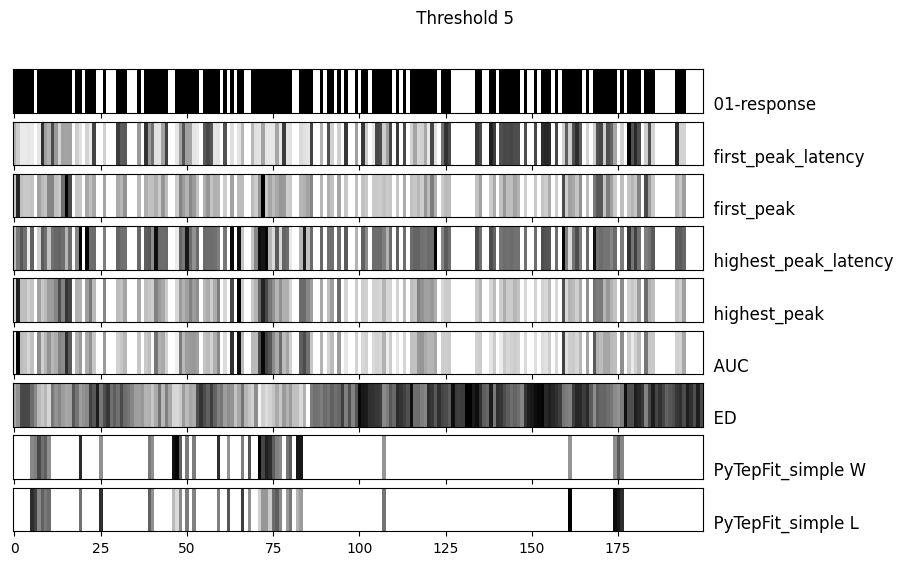

In [692]:
thr = list_of_thresholds[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = plotting.prepare_barcode(n_of_response_def+3,200, title = f" Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

plotting.plot_one_barcode(axs[-2],SC_W_log[stim_locatin],title=f"{name} W")
if SC_L is not None:
    plotting.plot_one_barcode(axs[-1],SC_L[stim_locatin],title=f"{name} L")

plotting.plot_one_barcode(axs[-3],ED[stim_locatin],title=f"ED")
plt.savefig(paths.path_figures(fig_dir+"barcode.pdf"),bbox_inches='tight',pad_inches=0)

Note: For Rosen and Halgren's preprocessing (`rh`), the structural connectivity weights are in [0,1] interval, so the logarithm is negative. Because of that, the corresponding row above has switched colors.

Create one multtiindex dataframe with all responses where the first index correspons to the threshold and the second index to ROIs:

In [693]:
all_responses = pd.concat(responses)
all_responses

01-response  first_peak_latency  first_peak  highest_peak_latency  \
4  0              1                47.0    5.816432                  47.0   
   1              1                30.0   21.778551                 104.0   
   2              1                13.0    6.474365                 128.0   
   3              1                13.0    5.517997                 109.0   
   4              1                15.0    5.643366                  15.0   
   5              1                13.0    6.014866                 121.0   
   6              0                 NaN         NaN                   NaN   
   7              1                16.0    9.252233                  37.0   
   8              1                69.0    4.224245                 126.0   
   9              1                14.0    4.299166                 111.0   
   10             1                14.0    4.981294                  47.0   
   11             1               110.0   12.757659                 110.0   
   12             1                14.0    4.086756                 116.0   
   13             1                16.0    4.278027                 119.0   
   14             1                57.0   14.741000                 112.0   
   15             1                21.0    4.228401                  56.0   
   16             1                57.0   18.418371                 112.0   
   17             0                 NaN         NaN                   NaN   
   18             1                20.0    4.623159                  93.0   
   19             1                18.0    5.488389                 195.0   
   20             1               195.0    4.942416                 195.0   
   21             1                27.0    8.867024                 194.0   
   22             1                13.0    6.553323                 112.0   
   23             1               114.0    9.108969                 114.0   
   24             0                 NaN         NaN                   NaN   
   25             1               121.0    4.839190                 128.0   
   26             1                18.0    4.472347                  99.0   
   27             0                 NaN         NaN                   NaN   
   28             1                98.0    4.149935                  98.0   
   29             1                94.0    4.691834                  94.0   
   30             1               119.0    8.634127                 119.0   
   31             1                99.0    7.412488                 111.0   
   32             1                16.0    4.611629                 110.0   
   33             0                 NaN         NaN                   NaN   
   34             0                 NaN         NaN                   NaN   
   35             0                 NaN         NaN                   NaN   
   36             1                62.0    6.999724                 116.0   
   37             0                 NaN         NaN                   NaN   
   38             1                64.0    4.992049                 124.0   
   39             1                61.0    6.379928                 129.0   
   40             1                87.0    6.515075                  87.0   
   41             1                18.0    8.297604                 185.0   
   42             1                17.0    5.366601                 114.0   
   43             1                57.0   10.743120                 113.0   
   44             1               115.0    6.712586                 115.0   
   45             0                 NaN         NaN                   NaN   
   46             0                 NaN         NaN                   NaN   
   47             1                16.0    5.211988                  16.0   
   48             1                57.0   12.511150                 118.0   
   49             1                36.0    4.763404                 103.0   
   50             1                58.0    7.698300                 177.0   
   5

## Correlations between response characteristics and communication metrics

In [694]:
def select_response_by_definition(definition,rdict):
    new_df = pd.DataFrame()
    for thr in rdict.keys():
        new_df[f"{thr:02d}"] = rdict[thr][definition]
    
    return new_df  

In [695]:
def corr_columns_of_two_matrices(responses_by_threshold,metrics):

    col_names_thresholds = list(responses_by_threshold.keys())
    col_names_SC = list(metrics.keys())

    df = pd.concat([responses_by_threshold,metrics], axis=1, join="inner")

    stat_pg = pg.pairwise_corr(df,columns=[col_names_thresholds,col_names_SC],method="spearman").round(3)

    return stat_pg

### Communication metrics

Get dataframe with columns corresponding to Euclidean distance, structural connectivity and communication metrics and rows corresponding to region pairs. 

|column name | description |
|---|---|
| ED    | Euclidean distance
| SC_W   | structural connectivity - weights
| SC_L   | structural connectivity - lengths
| SPE   | shortest path efficiency
| SPE_W | shortest path efficiency with 1/SC_W instead of SC_L 
| COM   | communicability
| SI    | search information
| SI_L  | search information with SC_L for path length
| NAV   | navigation efficiency
| DIF   | diffusion efficiency

In [696]:
# supress warnings - all the warnings we saw were about zero division,
# they result into nans in matrices, but they can not cause any issues
# (we checked the code where the warnings occured)
with warnings.catch_warnings(): 
    warnings.simplefilter('ignore')
    com_metrics_matrices = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

dict_metrics = {}
for c in com_metrics_matrices:
    dict_metrics[c] = com_metrics_matrices[c][stim_locatin]

df_metrics = pd.DataFrame(dict_metrics)
df_metrics

,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
0,45.307805,0.0,inf,0.009883,301.429932,0.000407,inf,16.261437,0.009883,0.001371
1,56.289608,0.0,inf,0.007724,315.561749,0.000210,inf,26.522402,0.003929,0.001245
2,92.766248,0.0,inf,0.007986,254.996741,0.000120,inf,17.697094,0.005159,0.000742
3,94.172221,0.0,inf,0.006371,383.289474,0.001747,inf,19.935134,0.006169,0.003293
4,92.564602,0.0,inf,0.006588,436.752477,0.001489,inf,11.156267,0.006299,0.002599
5,75.104399,36.0,126.337012,0.007915,424.329335,0.005453,8.434512,8.434512,0.007915,0.005355
6,59.889275,46.0,113.501234,0.008810,444.885617,0.007233,8.080875,8.080875,0.008810,0.004691
7,35.839675,237.0,71.197201,0.014045,527.555754,0.030047,5.715694,5.715694,0.014045,0.002944
8,27.989925,77.0,93.536129,0.012873,462.170978,0.012288,7.337651,9.217873,0.010691,0.004212
9,36.892542,122.0,80.390439,0.013973,540.419807,0.015758,6.673700,8.544339,0.012439,0.005494


For each response characteristic (or selected characteristics based on the list in the next cell) and all the thresholds, calculate correlation between the response for that threshold and the structural connectivity matrices and communication metrics. Plot the results, the color denotes the absolute value of the correlation. If the entry is missing in the plot, the correlation was nonsignificant ($p>0.05$).

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,200,-0.183,"[-0.31, -0.05]",0.009,0.741
1,04,SC_W,spearman,two-sided,200,0.103,"[-0.04, 0.24]",0.145,0.308
2,04,SC_L,spearman,two-sided,200,-0.111,"[-0.25, 0.03]",0.118,0.346
3,04,SPE,spearman,two-sided,200,0.164,"[0.03, 0.3]",0.020,0.645
4,04,SPE_W,spearman,two-sided,200,0.018,"[-0.12, 0.16]",0.795,0.058
5,04,COM,spearman,two-sided,200,0.131,"[-0.01, 0.26]",0.065,0.455
6,04,SI,spearman,two-sided,199,-0.105,"[-0.24, 0.04]",0.142,0.313
7,04,SI_L,spearman,two-sided,199,-0.134,"[-0.27, 0.01]",0.060,0.472
8,04,NAV,spearman,two-sided,200,0.202,"[0.07, 0.33]",0.004,0.823
9,04,DIF,spearman,two-sided,200,-0.284,"[-0.41, -0.15]",0.000,0.984


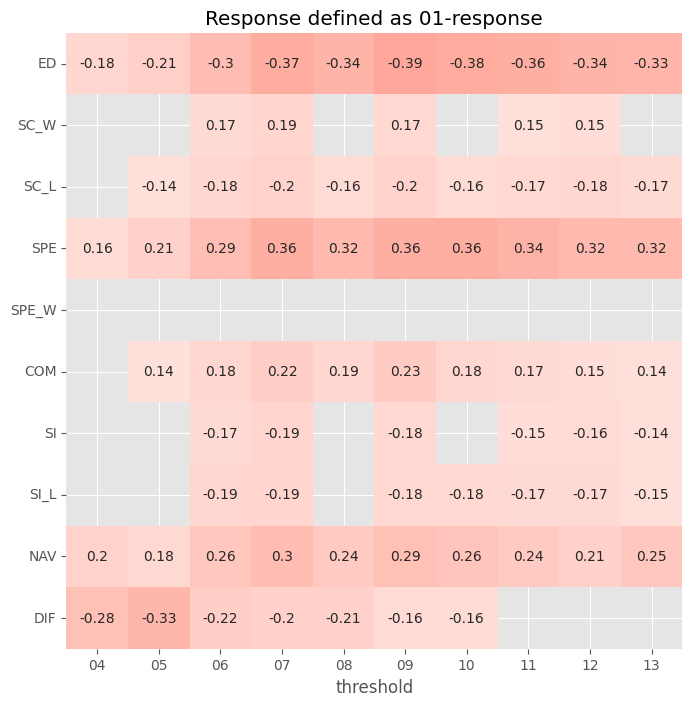

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.283,"[-0.42, -0.13]",0.000,0.952
1,04,SC_W,spearman,two-sided,157,0.125,"[-0.03, 0.28]",0.120,0.345
2,04,SC_L,spearman,two-sided,157,-0.158,"[-0.31, -0.0]",0.048,0.509
3,04,SPE,spearman,two-sided,157,0.300,"[0.15, 0.44]",0.000,0.971
4,04,SPE_W,spearman,two-sided,157,0.149,"[-0.01, 0.3]",0.062,0.464
5,04,COM,spearman,two-sided,157,0.199,"[0.04, 0.34]",0.012,0.709
6,04,SI,spearman,two-sided,156,-0.130,"[-0.28, 0.03]",0.106,0.367
7,04,SI_L,spearman,two-sided,156,-0.153,"[-0.3, 0.0]",0.057,0.479
8,04,NAV,spearman,two-sided,157,0.228,"[0.07, 0.37]",0.004,0.823
9,04,DIF,spearman,two-sided,157,-0.060,"[-0.21, 0.1]",0.453,0.117


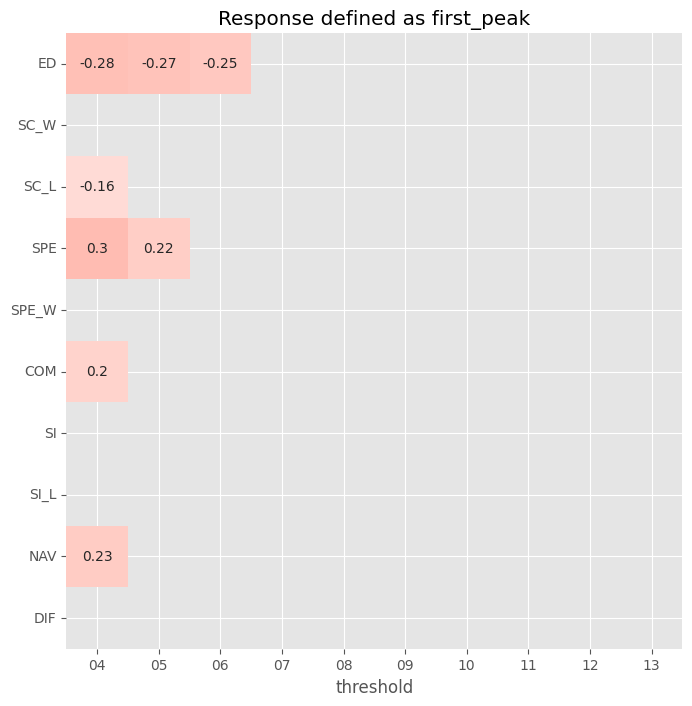

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.286,"[0.14, 0.42]",0.000,0.955
1,04,SC_W,spearman,two-sided,157,-0.302,"[-0.44, -0.15]",0.000,0.973
2,04,SC_L,spearman,two-sided,157,0.319,"[0.17, 0.45]",0.000,0.985
3,04,SPE,spearman,two-sided,157,-0.329,"[-0.46, -0.18]",0.000,0.989
4,04,SPE_W,spearman,two-sided,157,-0.263,"[-0.4, -0.11]",0.001,0.919
5,04,COM,spearman,two-sided,157,-0.244,"[-0.39, -0.09]",0.002,0.871
6,04,SI,spearman,two-sided,156,0.308,"[0.16, 0.44]",0.000,0.977
7,04,SI_L,spearman,two-sided,156,0.255,"[0.1, 0.4]",0.001,0.899
8,04,NAV,spearman,two-sided,157,-0.275,"[-0.41, -0.12]",0.000,0.940
9,04,DIF,spearman,two-sided,157,0.032,"[-0.13, 0.19]",0.692,0.068


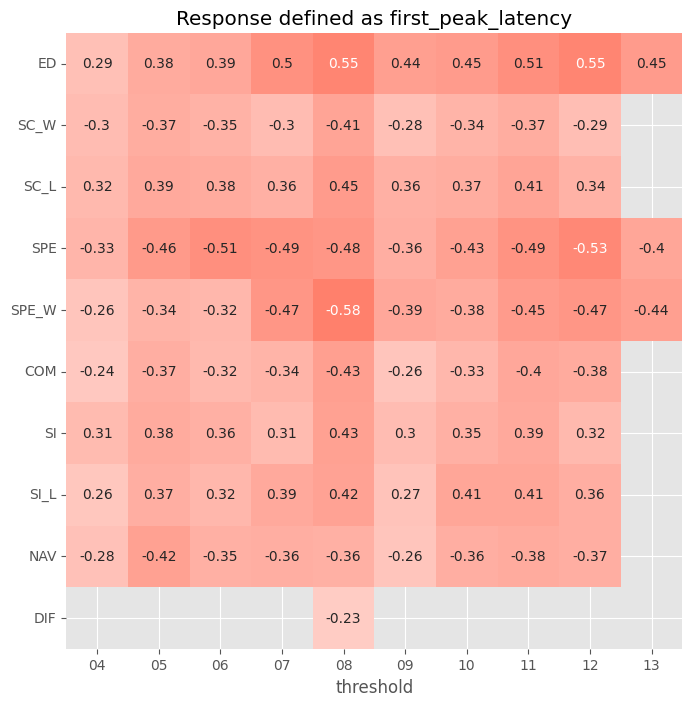

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.403,"[-0.53, -0.26]",0.000,1.000
1,04,SC_W,spearman,two-sided,157,0.169,"[0.01, 0.32]",0.034,0.567
2,04,SC_L,spearman,two-sided,157,-0.194,"[-0.34, -0.04]",0.015,0.687
3,04,SPE,spearman,two-sided,157,0.379,"[0.24, 0.51]",0.000,0.999
4,04,SPE_W,spearman,two-sided,157,0.115,"[-0.04, 0.27]",0.153,0.299
5,04,COM,spearman,two-sided,157,0.195,"[0.04, 0.34]",0.015,0.690
6,04,SI,spearman,two-sided,156,-0.174,"[-0.32, -0.02]",0.030,0.589
7,04,SI_L,spearman,two-sided,156,-0.165,"[-0.31, -0.01]",0.040,0.541
8,04,NAV,spearman,two-sided,157,0.251,"[0.1, 0.39]",0.002,0.890
9,04,DIF,spearman,two-sided,157,-0.104,"[-0.26, 0.05]",0.195,0.255


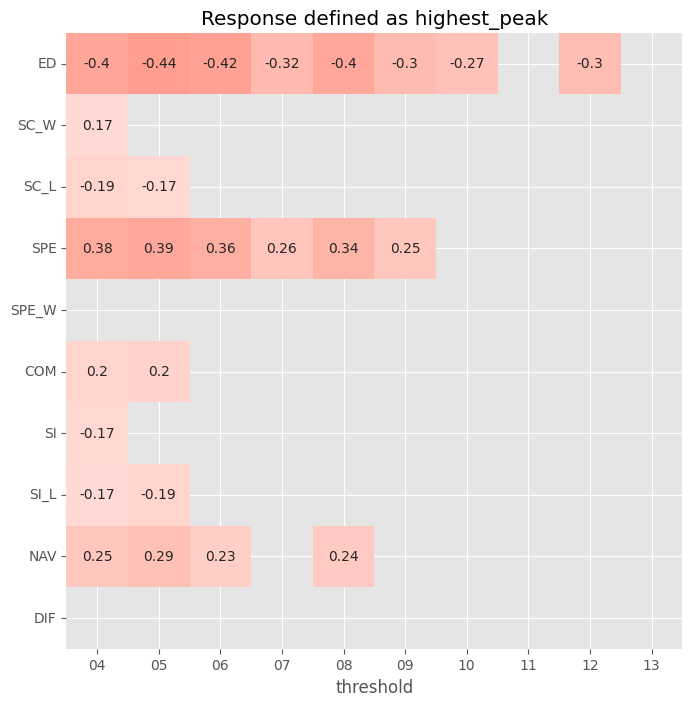

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.121,"[-0.04, 0.27]",0.131,0.329
1,04,SC_W,spearman,two-sided,157,-0.097,"[-0.25, 0.06]",0.227,0.227
2,04,SC_L,spearman,two-sided,157,0.144,"[-0.01, 0.29]",0.072,0.438
3,04,SPE,spearman,two-sided,157,-0.141,"[-0.29, 0.02]",0.078,0.423
4,04,SPE_W,spearman,two-sided,157,-0.136,"[-0.29, 0.02]",0.088,0.401
5,04,COM,spearman,two-sided,157,-0.153,"[-0.3, 0.0]",0.055,0.485
6,04,SI,spearman,two-sided,156,0.100,"[-0.06, 0.25]",0.212,0.240
7,04,SI_L,spearman,two-sided,156,0.121,"[-0.04, 0.27]",0.134,0.324
8,04,NAV,spearman,two-sided,157,-0.170,"[-0.32, -0.01]",0.033,0.570
9,04,DIF,spearman,two-sided,157,0.095,"[-0.06, 0.25]",0.238,0.219


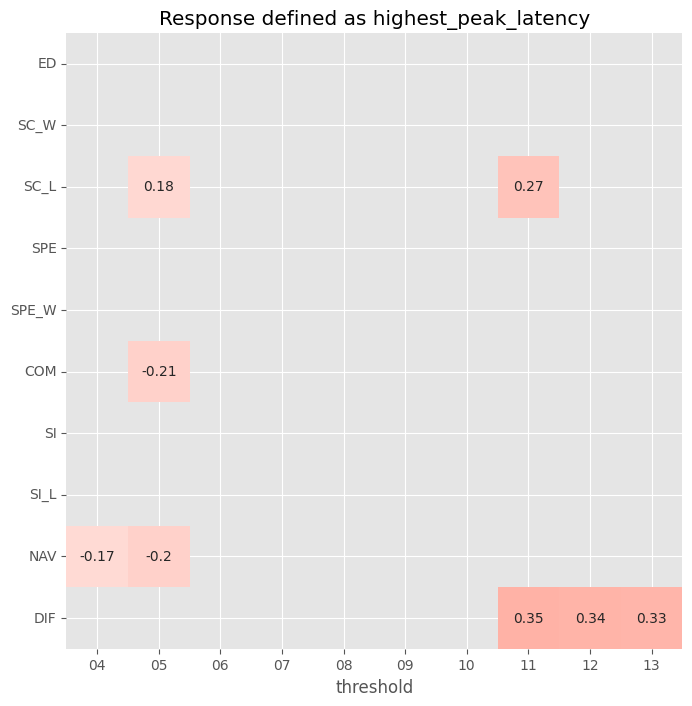

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.456,"[-0.57, -0.32]",0.000,1.000
1,04,SC_W,spearman,two-sided,157,0.277,"[0.13, 0.42]",0.000,0.943
2,04,SC_L,spearman,two-sided,157,-0.297,"[-0.43, -0.15]",0.000,0.968
3,04,SPE,spearman,two-sided,157,0.452,"[0.32, 0.57]",0.000,1.000
4,04,SPE_W,spearman,two-sided,157,0.238,"[0.08, 0.38]",0.003,0.856
5,04,COM,spearman,two-sided,157,0.289,"[0.14, 0.43]",0.000,0.959
6,04,SI,spearman,two-sided,156,-0.283,"[-0.42, -0.13]",0.000,0.951
7,04,SI_L,spearman,two-sided,156,-0.250,"[-0.39, -0.1]",0.002,0.888
8,04,NAV,spearman,two-sided,157,0.330,"[0.18, 0.46]",0.000,0.989
9,04,DIF,spearman,two-sided,157,-0.002,"[-0.16, 0.15]",0.982,0.050


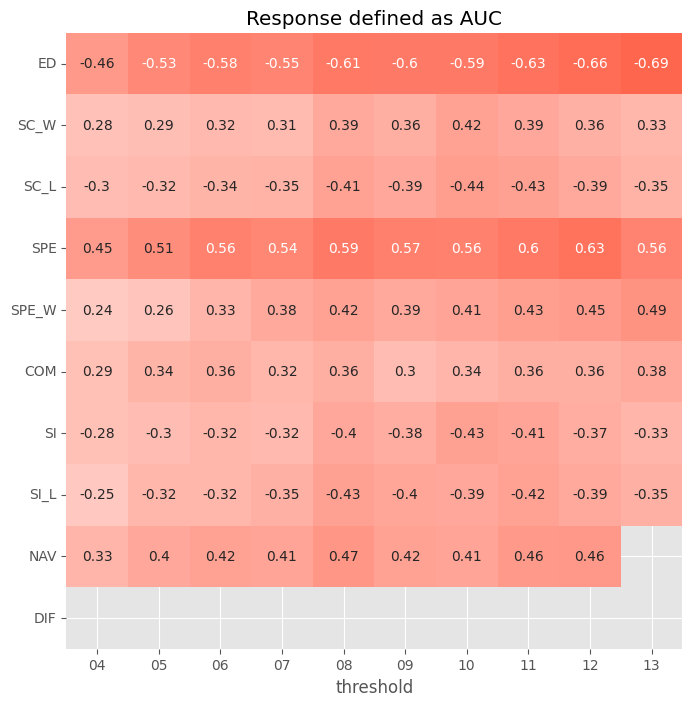

In [697]:
selected_response_definitions= ['01-response', 'first_peak', 'first_peak_latency', 'highest_peak', 'highest_peak_latency', 'AUC']
pd.set_option('display.max_rows', None)

plt.style.use('ggplot')
for i,resp_definition in enumerate(selected_response_definitions):
    responses_df = select_response_by_definition(resp_definition,responses)  
    
    df = corr_columns_of_two_matrices(responses_df,df_metrics)
    display(df)
    plotting.plot_df_as_heatmap(df,"Y","X","r",p="p-unc",fig_dir=fig_dir,title=f"Response defined as {resp_definition}")


Save selected responses so that we can use them in a following analysis in [03_compare_f-tract_pytepfit/02_dice-mapping.ipynb](../03_compare_f-tract_pytepfit/02_dice-mapping.ipynb):

In [698]:
df_metrics['label'] = data_pytepfit['labels']

df_metrics_AUC = df_metrics.copy()
df_metrics_01 = df_metrics.copy()
df_metrics_FPT = df_metrics.copy()

for thr in list(responses.keys()):
    df_metrics_AUC["response"] = responses[thr]["AUC"]
    df_metrics_01["response"] = responses[thr]["01-response"]
    df_metrics_FPT["response"] = responses[thr]["first_peak_latency"]

    df_metrics_AUC_id = df_metrics_AUC.set_index('label')
    df_metrics_01_id = df_metrics_01.set_index('label')
    df_metrics_FPT_id = df_metrics_FPT.set_index('label')

    df_metrics_AUC_id.to_csv(paths.path(f'{results_dir}response_AUC_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))
    df_metrics_01_id.to_csv(paths.path(f'{results_dir}response_01_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))
    df_metrics_FPT_id.to_csv(paths.path(f'{results_dir}response_FP_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))